In [1]:
import sys
sys.path.append("../")

# Evaluation

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, ToPILImage

from model import UNet
from predict import Predictor
from data import NucleusDataset
from transform import Rescale
from metrics import iou_score
from losses import bce_and_dice

Load the training and test data sets

In [6]:
train_dataset = NucleusDataset("../data", train=True, 
                               transform=Compose([
                                   Rescale(256)
                    
                               ]),
                               target_transform=Compose([
                                   Rescale(256)
                               ]))
test_dataset = NucleusDataset("../data", train=False,
                              transform=Compose([
                                   Rescale(256)
                               ]))

100%|██████████| 65/65 [00:00<00:00, 134.69it/s]


Load the pretrained `UNet` model at different stages of training, specifically after **80**, **120** and **160** epochs.

In [18]:
model80 = UNet.load("../models/test1/weights_e:80_loss:0.1441.pt")
model120 = UNet.load("../models/test2/weights_e:40_loss:0.0709.pt")
model160 = UNet.load("../models/test3/weights_e:40_loss:0.0496.pt")

Loading UNet from path `../models/test1/weights_e:80_loss:0.1441.pt`
Loading UNet from path `../models/test2/weights_e:40_loss:0.0709.pt`
Loading UNet from path `../models/test3/weights_e:40_loss:0.0496.pt`


Create `Predictor`, wrapper class that's going to handle all the pre and post-processing steps, for each of the models.

In [19]:
predict80 = Predictor(model80)
predict120 = Predictor(model120)
predict160 = Predictor(model160)

Plot some of the images and masks from the dataset, as well as model predictions. In this case, **model80** will be used.

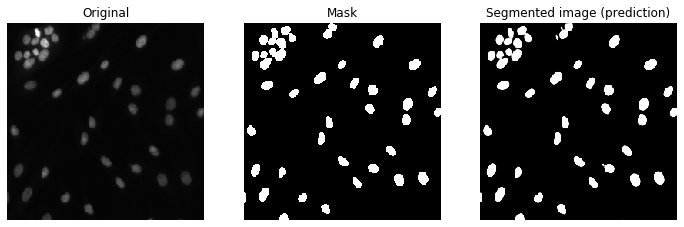

In [23]:
idx = random.randint(0, len(train_dataset)-1)
image, mask = train_dataset[idx]

segmented = predict80(image)

fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Original')

axes[1].imshow(mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Mask')

axes[2].imshow(segmented, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Segmented image (prediction)')

plt.show()

In [10]:
print(idx)

313


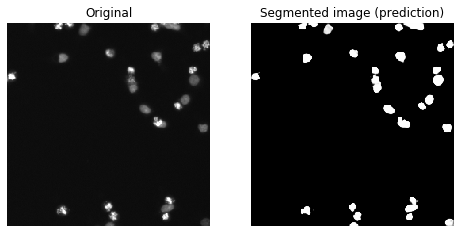

In [24]:
idx = random.randint(0, len(test_dataset)-1)
image = test_dataset[idx]

segmented = predict80(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 10))
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Original')

axes[1].imshow(segmented, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Segmented image (prediction)')

plt.show()

## Overfitting issues

Let's examine how models at different epochs compare to each other on worst examples.

In [27]:
to_tensor = ToTensor()  # Converts numpy or PIL image to torch.Tensor

def compute_loss(segmented, mask):
    """
    Computes Binary Cross-Entropy + Dice loss for given segmented image and original mask.
    """
    segmented_tensor = to_tensor(segmented)
    mask_tensor = to_tensor(mask)
    
    segmented_tensor = segmented_tensor.unsqueeze(0)  # Add batch dim
    mask_tensor = mask_tensor.unsqueeze(0)  # Add batch dim
    
    loss = bce_and_dice(segmented_tensor, mask_tensor)
    
    return loss.item()

Obtain loss for every image in the **train data set** and save them.

In [35]:
data = []
for i in tqdm(range(len(train_dataset))):
    img, mask = train_dataset[i]
    segmented = predict80(img)
    
    loss = compute_loss(segmented, mask)
    data.append({
        "loss": loss,
        "img": img,
        "segmented": segmented,
        "mask": mask,
        "idx": i
    })

100%|██████████| 670/670 [02:28<00:00,  4.51it/s]


Now `data` list can be sorted by losses obtained.

In [38]:
data.sort(key=lambda x: x["loss"], reverse=True)

Examine top 10 worst images (highest loss)

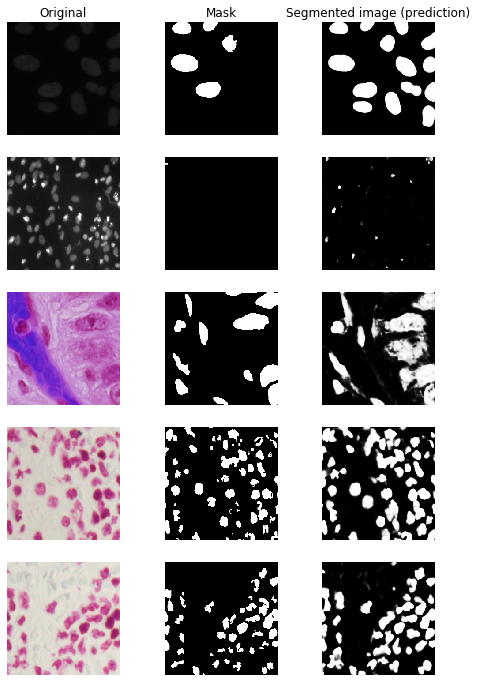

In [47]:
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(8, 12))

axes[0][0].set_title('Original')
axes[0][1].set_title('Mask')
axes[0][2].set_title('Segmented image (prediction)')

for i in range(num_samples):
    axes[i][0].imshow(data[i]['img'])
    axes[i][0].axis('off')

    axes[i][1].imshow(data[i]['mask'], cmap='gray')
    axes[i][1].axis('off')
    
    axes[i][2].imshow(data[i]['segmented'], cmap='gray')
    axes[i][2].axis('off')

To examine more the **1st** example where mask is wrongly labelled, but prediction is correct.

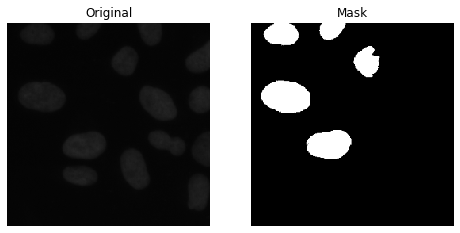

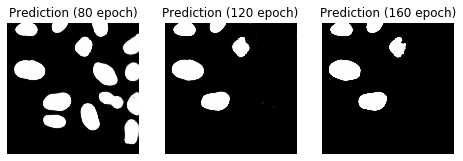

In [54]:
segmented_image80 = predict80(data[0]['img'])
segmented_image120 = predict120(data[0]['img'])
segmented_image160 = predict160(data[0]['img'])

# First subplot with original image and mask
fig, axes = plt.subplots(1, 2, figsize=(8, 12))
axes[0].imshow(data[0]['img'])
axes[0].axis('off')
axes[0].set_title("Original")

axes[1].imshow(data[0]['mask'], cmap='gray')
axes[1].axis('off')
axes[1].set_title("Mask")

# Second subplot with prediction from 3 models at different stages of training
fig, axes = plt.subplots(1, 3, figsize=(8, 12))
axes[0].imshow(segmented_image80, cmap="gray")
axes[0].axis('off')
axes[0].set_title("Prediction (80 epoch)")

axes[1].imshow(segmented_image120, cmap="gray")
axes[1].axis('off')
axes[1].set_title("Prediction (120 epoch)")

axes[2].imshow(segmented_image160, cmap="gray")
axes[2].axis('off')
axes[2].set_title("Prediction (160 epoch)")

plt.show()

After 80 epoch the models starts to overfit... :(

## Generalization Issues

Does the models really learn how nuclei should look like? Let's give it something that is certainly not nuclei, but is in the same pixel value range.

In [72]:
nuclei_img = cv2.imread("nuclei.png")

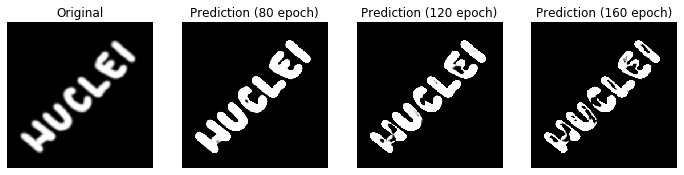

In [77]:
# Run forward pass
segmented_image80 = predict80(nuclei_img)
segmented_image120 = predict120(nuclei_img)
segmented_image160 = predict160(nuclei_img)

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(12, 12))
axes[0].imshow(nuclei_img, cmap="gray")
axes[0].axis('off')
axes[0].set_title("Original")

axes[1].imshow(segmented_image80, cmap="gray")
axes[1].axis('off')
axes[1].set_title("Prediction (80 epoch)")

axes[2].imshow(segmented_image120, cmap="gray")
axes[2].axis('off')
axes[2].set_title("Prediction (120 epoch)")

axes[3].imshow(segmented_image160, cmap="gray")
axes[3].axis('off')
axes[3].set_title("Prediction (160 epoch)")

plt.show()

Yeah, the models doesn't really have sense of nuclei shape, it mostly look at the color (black/white)...